In [1]:
import pathlib, os, sys
import numpy as np
import cv2, pygame, scipy, h5py
import matplotlib.pyplot as plt
from PIL import Image

%load_ext autoreload
%autoreload 2

pygame 2.0.0 (SDL 2.0.12, python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Semseg mask test

In [2]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import torch

filename = 'seg_inputs/sample0.jpg'
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

#model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

Downloading: "https://github.com/pytorch/vision/archive/v0.8.0.zip" to /root/.cache/torch/hub/v0.8.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [3]:
print(output_predictions.shape, input_tensor.shape)
print(np.unique(output_predictions.cpu().numpy()))

torch.Size([706, 1200]) torch.Size([3, 706, 1200])
[ 0 15]


/tmp/ipykernel_11/710754343.py:19: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(img_as_float(image), n_segments = 30 , sigma = 5)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 0  0  0 ... 17 17 17]
(847200,)
dict_items([(0, 131114), (1, 20895), (2, 22753), (3, 71917), (4, 41646), (5, 72462), (6, 40370), (7, 50209), (8, 20678), (9, 47779), (10, 40010), (11, 17365), (12, 28177), (13, 46706), (14, 32056), (15, 43056), (16, 49887), (17, 46225), (18, 23895)]) [131114, 20895, 22753, 71917, 41646, 72462, 40370, 50209, 20678, 47779, 40010, 17365, 28177, 46706, 32056, 43056, 49887, 46225, 23895] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


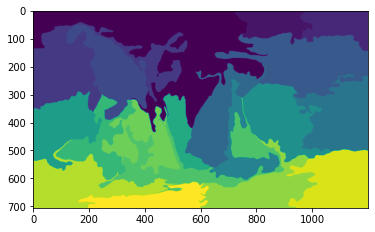

In [4]:
from __future__ import division
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import argparse
import cv2
import h5py
import numpy as np
import multiprocessing as mp
import traceback, sys
from collections import Counter
import sys

filename = 'seg_inputs/sample0.jpg'
image = cv2.imread(filename)
segments = slic(img_as_float(image), n_segments = 30 , sigma = 5)
plt.imshow(segments)
print(np.unique(segments))

areas = []
labels=[]

shape = segments.shape
s = segments.reshape(segments.shape[1]*segments.shape[0])
print(s)

word_count = Counter(s)
occ=word_count.items()

for i in occ:
    areas.append(i[1])
    labels.append(i[0]+1)
print(s.shape)
print(occ, areas, labels)

## Depth Estimation test

In [5]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)

midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


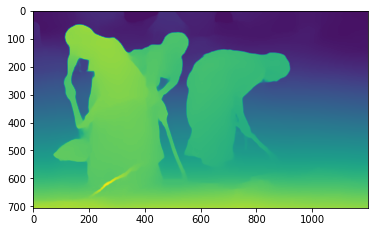

In [7]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth = prediction.cpu().numpy()
plt.imshow(depth)

## Try calling render_text()

In [9]:
import numpy as np
import h5py
import os, sys, traceback
import os.path as osp
from synthgen import *
from common import *

seg = segments
print(seg.shape)

#depth = output
img = Image.open(filename)
print(seg[:5], depth[:5])
#raise
area = np.array(areas)
label = np.array(labels)
INSTANCE_PER_IMAGE = 5

# re-size uniformly:
#sz = depth.shape[:2][::-1]
sz = depth.shape[:2][::-1]
print(sz) # (1200, 706)
img = np.array(img.resize(sz, Image.ANTIALIAS))
##seg = np.array(Image.fromarray(seg).resize(sz, Image.NEAREST))
segr = cv2.resize(seg, sz, interpolation=cv2.INTER_NEAREST)

from synthgen import *
from common import *
DATA_PATH = 'data'
SECS_PER_IMG = 1
viz = False

RV3 = RendererV3(DATA_PATH,max_time=SECS_PER_IMG)
#print(colorize(Color.RED,'%d of %d'%(i,end_idx-1), bold=True))
res = RV3.render_text(img,depth,seg, area,label,
                    ninstance=INSTANCE_PER_IMAGE,viz=viz)
print(res)

(706, 1200)
[[0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]] [[0.4298683  0.4154125  0.3943348  ... 0.         0.         0.        ]
 [0.40406385 0.40169492 0.39857963 ... 0.         0.         0.        ]
 [0.36855426 0.3831163  0.40514648 ... 0.         0.         0.        ]
 [0.37719727 0.3898996  0.40898794 ... 0.         0.         0.        ]
 [0.41291377 0.41270787 0.4124439  ... 0.         0.         0.        ]]
(1200, 706)
 ** instance # : 0
 ** instance # : 1
 ** instance # : 2
   *** Timed out!
   *** Timed out!
   *** Timed out!
   *** Timed out!
   *** Timed out!
 ** instance # : 3
 ** instance # : 4
[{'img': array([[[212, 209, 202],
        [214, 211, 204],
        [216, 213, 208],
        ...,
        [205, 202, 197],
        [204, 201, 196],
        [204, 201, 196]],

       [[201, 201, 193],
        [202, 202, 194],
        [207, 204, 197],
        ...,
        [205, 202, 197],
        [204, 201, 196],
        [204, 201

In [10]:
print(len(res), res[0].keys())
print(res[0]['img'].shape)

5 dict_keys(['img', 'charBB', 'wordBB', 'txt'])
(706, 1200, 3)


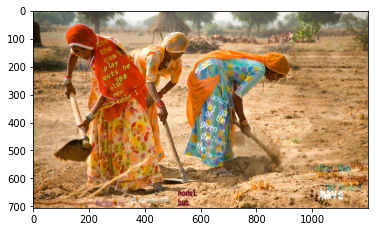

In [11]:
#Image.fromarray(res[0]['img']).save('output0.png')
plt.imshow(res[0]['img'])